In [ ]:
import warnings
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns
import os
import yfinance as yf
from scipy import stats
from scipy.stats import norm, lognorm, t
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


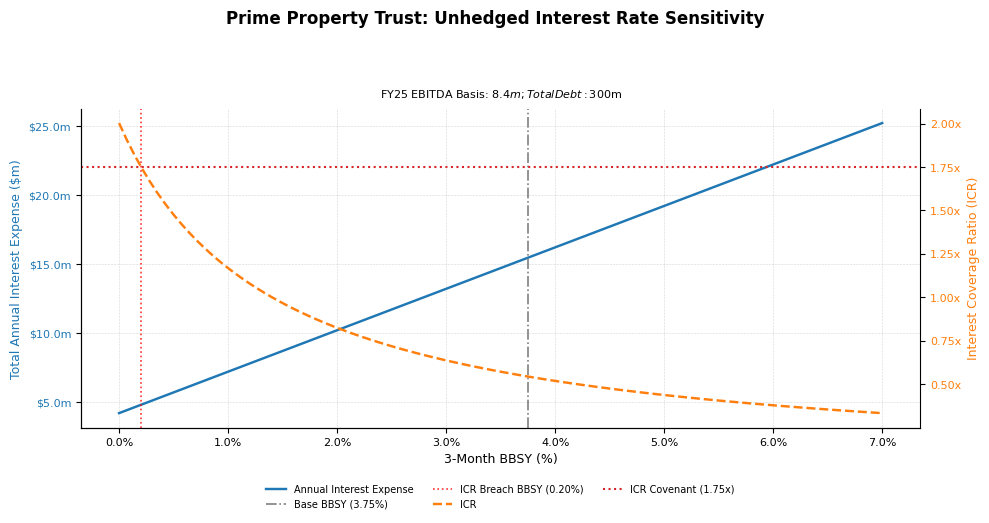

In [9]:
plots_dir: str = "plots"

def plot_unhedged_sensitivity(principal_1, spread_1, principal_2, spread_2, 
                              ebitda, icr_covenant, base_bbsy_pct, 
                              min_bbsy_pct=0.0, max_bbsy_pct=7.0, num_pts=101, currency_sym="$"):
    
    bbsy_rates = np.linspace(min_bbsy_pct / 100.0, max_bbsy_pct / 100.0, num_pts)
    
    interest_1 = principal_1 * (bbsy_rates + spread_1)
    interest_2 = principal_2 * (bbsy_rates + spread_2)
    total_interest = interest_1 + interest_2
    
    icr_values = np.full_like(total_interest, np.nan)
    mask = total_interest != 0
    icr_values[mask] = ebitda / total_interest[mask]
    
    interest_at_covenant = ebitda / icr_covenant
    fixed_interest_comp = (principal_1 * spread_1) + (principal_2 * spread_2)
    total_principal = principal_1 + principal_2
    bbsy_at_covenant_breach = ((interest_at_covenant - fixed_interest_comp) / total_principal) if total_principal > 0 else np.nan

    fig, ax1 = plt.subplots(figsize=(10, 6)) # Adjusted size slightly
    fig.patch.set_facecolor('white')
    ax1.set_facecolor('white')

    color_interest = '#1f77b4'
    ax1.set_xlabel("3-Month BBSY (%)", fontsize=9)
    ax1.set_ylabel(f"Total Annual Interest Expense ({currency_sym}m)", color=color_interest, fontsize=9) # Assuming amounts in millions
    ax1.plot(bbsy_rates * 100, total_interest / 1000, color=color_interest, linewidth=1.75, label="Annual Interest Expense") # Convert '000s to millions for Y axis
    ax1.tick_params(axis='y', labelcolor=color_interest, labelsize=8)
    ax1.tick_params(axis='x', labelsize=8)
    ax1.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'{currency_sym}{y:,.1f}m'))

    ax2 = ax1.twinx()
    color_icr = '#ff7f0e'
    ax2.set_ylabel("Interest Coverage Ratio (ICR)", color=color_icr, fontsize=9)
    ax2.plot(bbsy_rates * 100, icr_values, color=color_icr, linewidth=1.75, linestyle='--', label="ICR")
    ax2.tick_params(axis='y', labelcolor=color_icr, labelsize=8)
    ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2fx'))

    ax2.axhline(icr_covenant, color='#d62728', linestyle=':', linewidth=1.5, label=f"ICR Covenant ({icr_covenant:.2f}x)")
    ax1.axvline(base_bbsy_pct, color='grey', linestyle='-.', linewidth=1.2, label=f"Base BBSY ({base_bbsy_pct:.2f}%)")
    if not np.isnan(bbsy_at_covenant_breach):
        ax1.axvline(bbsy_at_covenant_breach * 100, color='red', linestyle=':', linewidth=1.2, alpha=0.8, label=f"ICR Breach BBSY ({bbsy_at_covenant_breach*100:.2f}%)")

    fig.suptitle("Prime Property Trust: Unhedged Interest Rate Sensitivity", fontsize=12, weight='bold')
    ax1.set_title(f"FY25 EBITDA Basis: {currency_sym}{ebitda/1000:,.1f}m; Total Debt: {currency_sym}{(total_principal)/1000:,.0f}m", fontsize=8, pad=8)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', fontsize=7, frameon=False, ncol=3, bbox_to_anchor=(0.5, -0.15))
    
    ax1.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False) # ax2 will superimpose its own right spine
    ax2.spines['top'].set_visible(False)

    plt.tight_layout(rect=[0, 0.08, 1, 0.93]) # Adjust layout
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)

    file_name = "Unhedged_Parameter_Sensitivity.png"
    file_path = os.path.join(plots_dir, file_name)
    fig_unhedged.savefig(file_path, dpi=1200, bbox_inches='tight')
    plt.show()
    return fig

p_pct = 100000  # $100m facility size, in '000s
s_pct = 0.0120  # Spread 1.20%

# Facility 2: Sterling Square (SS)
p_ss = 200000   # $200m facility size, in '000s
s_ss = 0.0150   # Spread 1.50%

# Financials for FY25 (the upcoming year of concern)
ebitda_fy25 = 8412  # Net Rentals (EBITDA) for FY25, in '000s
bbsy_fy25_base_pct = 3.75 # Base Case BBSY (%) for FY25

# Covenant
icr_target = 1.75

# Generate and display the plot
fig_unhedged = plot_unhedged_sensitivity(
    principal_1=p_pct, spread_1=s_pct,
    principal_2=p_ss, spread_2=s_ss,
    ebitda=ebitda_fy25, 
    icr_covenant=icr_target,
    base_bbsy_pct=bbsy_fy25_base_pct,
    min_bbsy_pct=0.0,  # Plot BBSY from 0%
    max_bbsy_pct=7.0,  # Up to 7%
    currency_sym="$"   # Set currency symbol
)






--- Hedged Scenario Outcomes (Futures Lock-in Yield: 3.85%) ---
Total Hedged Annual Interest Expense (for $0m debt): $15.8m
Resulting Hedged ICR (with FY25 EBITDA of $8.4m): 0.53x
Figure saved to: plots/Futures_Hedging_Outcomes_PerContract.png


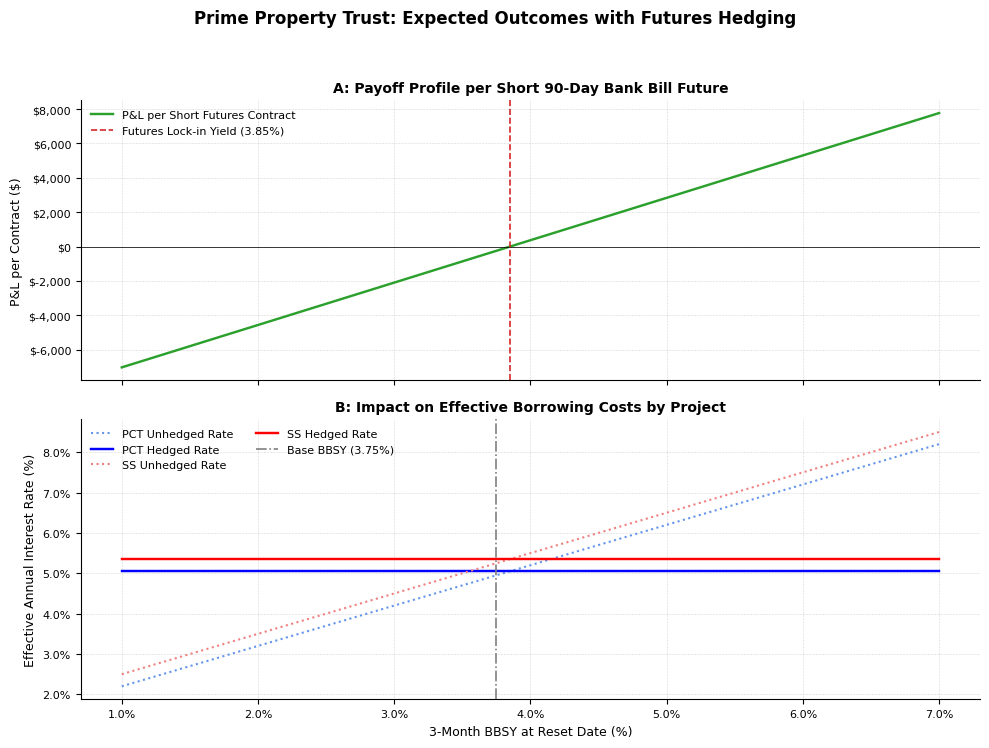

In [20]:
def plot_futures_hedging_outcomes(
    principal_1, spread_1, 
    principal_2, spread_2,
    ebitda_for_icr, 
    futures_sale_yield_pct, 
    base_bbsy_pct, 
    min_bbsy_pct=0.0,
    max_bbsy_pct=7.0,
    num_pts=101,
    currency_sym="$",
    contract_face_value=1000000, 
    contract_days=90
    # Removed save_dir and file_name_prefix from params to use global/fixed ones
):
    
    futures_sale_yield = futures_sale_yield_pct / 100.0
    bbsy_rates = np.linspace(min_bbsy_pct / 100.0, max_bbsy_pct / 100.0, num_pts)
    
    # --- Panel A: P&L of ONE SHORT Futures Contract ---
    # P&L for one short contract: Face_Value * (Actual_Yield - Locked_In_Yield) * (Days/365)
    # Profit if actual rates (bbsy_rates) > futures_sale_yield
    futures_pnl_per_contract = contract_face_value * (bbsy_rates - futures_sale_yield) * (contract_days / 365.0)

    # --- Panel B: Effective Interest Rates (for total principal) ---
    unhedged_rate_1 = bbsy_rates + spread_1
    unhedged_rate_2 = bbsy_rates + spread_2
    
    hedged_rate_1_val = futures_sale_yield + spread_1
    hedged_rate_2_val = futures_sale_yield + spread_2
    
    hedged_rate_1_plot = np.full_like(bbsy_rates, hedged_rate_1_val)
    hedged_rate_2_plot = np.full_like(bbsy_rates, hedged_rate_2_val)
        
    fig, (ax_pnl, ax_rates) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    fig.patch.set_facecolor('white')
    
    ax_pnl.set_facecolor('white')
    # Plot P&L per contract. Y-axis will be in actual currency units, not thousands or millions yet for per contract.
    ax_pnl.plot(bbsy_rates * 100, futures_pnl_per_contract, color='#2ca02c', linewidth=1.75, label="P&L per Short Futures Contract")
    ax_pnl.axhline(0, color='black', linewidth=0.6, linestyle='-', alpha=0.9)
    ax_pnl.axvline(futures_sale_yield_pct, color='#d62728', linestyle='--', linewidth=1.2, label=f'Futures Lock-in Yield ({futures_sale_yield_pct:.2f}%)')
    ax_pnl.set_ylabel(f"P&L per Contract ({currency_sym})", fontsize=9) # Y-axis label changed
    ax_pnl.set_title("A: Payoff Profile per Short 90-Day Bank Bill Future", fontsize=10, weight='bold')
    ax_pnl.legend(fontsize=8, loc='upper left', frameon=False)
    ax_pnl.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_pnl.tick_params(axis='y', labelsize=8)
    ax_pnl.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, p: f'{currency_sym}{y:,.0f}')) # Format as currency
    ax_pnl.spines['top'].set_visible(False)
    ax_pnl.spines['right'].set_visible(False)
    ax_pnl.tick_params(axis='x', labelsize=8, direction='out', pad=4)

    ax_rates.set_facecolor('white')
    ax_rates.plot(bbsy_rates * 100, unhedged_rate_1 * 100, color='cornflowerblue', linestyle=':', linewidth=1.5, label="PCT Unhedged Rate")
    ax_rates.plot(bbsy_rates * 100, hedged_rate_1_plot * 100, color='blue', linewidth=1.75, label="PCT Hedged Rate")
    ax_rates.plot(bbsy_rates * 100, unhedged_rate_2 * 100, color='lightcoral', linestyle=':', linewidth=1.5, label="SS Unhedged Rate")
    ax_rates.plot(bbsy_rates * 100, hedged_rate_2_plot * 100, color='red', linewidth=1.75, label="SS Hedged Rate")
    ax_rates.axvline(base_bbsy_pct, color='grey', linestyle='-.', linewidth=1.2, label=f"Base BBSY ({base_bbsy_pct:.2f}%)")
    ax_rates.set_xlabel("3-Month BBSY at Reset Date (%)", fontsize=9)
    ax_rates.set_ylabel("Effective Annual Interest Rate (%)", fontsize=9)
    ax_rates.set_title("B: Impact on Effective Borrowing Costs by Project", fontsize=10, weight='bold')
    ax_rates.legend(fontsize=8, loc='upper left', frameon=False, ncol=2)
    ax_rates.grid(True, linestyle=':', linewidth=0.4, alpha=0.6, color='grey')
    ax_rates.tick_params(axis='both', labelsize=8, direction='out', pad=4)
    ax_rates.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_rates.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax_rates.spines['top'].set_visible(False)
    ax_rates.spines['right'].set_visible(False)

    fig.suptitle("Prime Property Trust: Expected Outcomes with Futures Hedging", fontsize=12, weight='bold')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
    
    hedged_annual_interest_1 = principal_1 * hedged_rate_1_val 
    hedged_annual_interest_2 = principal_2 * hedged_rate_2_val
    total_hedged_annual_interest = hedged_annual_interest_1 + hedged_annual_interest_2
    
    hedged_icr = np.nan
    if total_hedged_annual_interest != 0:
        hedged_icr = ebitda_for_icr / total_hedged_annual_interest
    
    print(f"\n--- Hedged Scenario Outcomes (Futures Lock-in Yield: {futures_sale_yield_pct:.2f}%) ---")
    total_principal_for_title = principal_1 + principal_2 # For title consistency
    print(f"Total Hedged Annual Interest Expense (for {currency_sym}{total_principal_for_title/1e6:.0f}m debt): {currency_sym}{total_hedged_annual_interest/1000:,.1f}m")
    print(f"Resulting Hedged ICR (with FY25 EBITDA of {currency_sym}{ebitda_for_icr/1000:,.1f}m): {hedged_icr:.2f}x")
    
    if not os.path.exists(plots_dir): 
        os.makedirs(plots_dir)
    
    file_name = "Futures_Hedging_Outcomes_PerContract.png"
    file_path = os.path.join(plots_dir, file_name)
    
    fig.savefig(file_path, dpi=1200, bbox_inches='tight')
    print(f"Figure saved to: {file_path}")
        
    plt.show()
    return fig

principal_pct_val = 100000 
spread_pct_val = 0.0120    
principal_ss_val = 200000   
spread_ss_val = 0.0150      
ebitda_fy25_val = 8412 
bbsy_fy25_base_pct = 3.75 

calibrated_futures_sale_yield_pct = 3.85 

fig_futures = plot_futures_hedging_outcomes(
    principal_1=principal_pct_val, spread_1=spread_pct_val,
    principal_2=principal_ss_val, spread_2=spread_ss_val,
    ebitda_for_icr=ebitda_fy25_val,
    futures_sale_yield_pct=calibrated_futures_sale_yield_pct,
    base_bbsy_pct=bbsy_fy25_base_pct,
    min_bbsy_pct=1.0, 
    max_bbsy_pct=7.0,
    currency_sym="$"
)